**Importing and Exploring** <br/>
We import the data and print it in order to get a sense of the type of data we are dealing with. Additionally we explore basic information such as the mean distribution of the "PAY" values based on if they were "Accepted" or "Declined" rides. 

In [1]:
import pandas as pd
data = pd.read_csv('driverAcceptanceData - driverAcceptanceData.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data

,PAY,ACCEPTED
0,29.358732,0
1,22.986847,0
2,18.020348,0
3,45.730717,1
4,14.642845,0
...,...,...
995,17.382310,0
996,20.855120,0
997,42.122166,1
998,10.853923,0


In [2]:
# Checking means
data_mean = data['PAY'].groupby(data['ACCEPTED']).mean()
df = pd.DataFrame(data_mean)
dfmean = df.T
dfmean.columns = [['Rejected', 'Accepted']]
dfmean

,Rejected,Accepted
PAY,18.624636,32.076048


**Raw Data Visualization** <br/>
We then proceed to visualize the data in order to get a better sense of the shape of the distribution.

<AxesSubplot: xlabel='ACCEPTED', ylabel='PAY'>

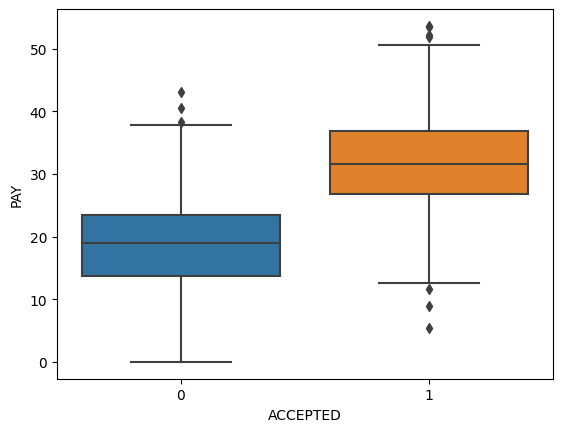

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(x=data['ACCEPTED'], y=data['PAY'])

At first glance it seems that both Accepted and Declined payment distributions adhere to a Gaussian/Normal distribution. However, there seems to be some outliers that should be dealt with before continuing our analysis.

In [4]:
# Getting rid of Outliers using the Interquartile method
import numpy as np
Declined = data[data['ACCEPTED']==0].reset_index(drop=True)
q75,q25 = np.percentile(Declined['PAY'], [75,25])
intr_qr = q75-q25
max = q75+(1.5*intr_qr)
min = q25-(1.5*intr_qr)
Declined[Declined["PAY"] < min] = np.nan
Declined[Declined["PAY"] > max] = np.nan

Accepted = data[data['ACCEPTED']==1].reset_index(drop=True)
q75,q25 = np.percentile(Accepted['PAY'], [75,25])
intr_qr = q75-q25
max = q75+(1.5*intr_qr)
min = q25-(1.5*intr_qr)
Accepted[Accepted["PAY"] < min] = np.nan
Accepted[Accepted["PAY"] > max] = np.nan


C:\Users\chiaw\AppData\Local\Temp\ipykernel_18420\92208927.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_clean = Accepted.append(Declined)


<AxesSubplot: xlabel='ACCEPTED', ylabel='PAY'>

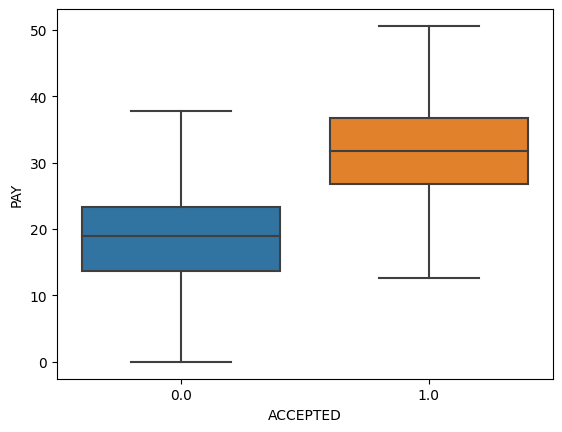

In [5]:
# Visualizaing new distributions
data_clean = Accepted.append(Declined)
sns.boxplot(x=data_clean['ACCEPTED'], y=data_clean['PAY'])

Once we have gotten rid of the outliers using an interquartile approach we can proceed to check our assumption of normal distribution. In order to do so we will employ a Shapiro-Wilks Test

In [6]:
from scipy.stats import shapiro 

#Shapiro-Wilk test for normality
print(shapiro(data_clean[data_clean['ACCEPTED']==1]['PAY']))
print(shapiro(data_clean[data_clean['ACCEPTED']==0]['PAY']))


ShapiroResult(statistic=0.9954842329025269, pvalue=0.13742683827877045)
ShapiroResult(statistic=0.9946429133415222, pvalue=0.10058016330003738)


The results from this test show a p-value of 0.14 and 0.10 for our Accepted and Declined distributions, values above our 0.05 threshold. Therefore we can assume that both distributions adhere to the characteristics of a normal distribution going forward with our analysis.

**Percentage of Ride Decline x Amount Payed**

 In order to asses the % of Driver Acceptance we must compare the proportion of
 Accepted vs Declined requests at every PAY point. Due to PAY being a continuous
 variable we will need to group them based on intervals. The smaller these intervals
 the more precise our measurements will be. However, given our small sample size of 1000
data points we wont be able to be very precise and will opt for an interval size of 1 $

In [7]:
# Distribution range
Min = int(data_clean['PAY'].min())
Max = int(round(data_clean['PAY'].max(), 0))
# Range of our distribution [0,51]

In [8]:
# Creating the intervals
import numpy as np
Accepted = data_clean[data_clean['ACCEPTED']==1]
Declined = data_clean[data_clean['ACCEPTED']==0]

# Set up
Intervals = []
start = 0
for i in range(0, 51):
    Intervals.append(start)
    start = start + 1

Accepted.loc[:,'Counter'] = 1
Declined.loc[:,'Counter'] = 1


Int_Accepted = Accepted.groupby(pd.cut(Accepted['PAY'], Intervals)).sum()
Int_Declined = Declined.groupby(pd.cut(Declined['PAY'], Intervals)).sum()


C:\Users\chiaw\AppData\Local\Temp\ipykernel_18420\860165478.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Accepted.loc[:,'Counter'] = 1
C:\Users\chiaw\AppData\Local\Temp\ipykernel_18420\860165478.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Declined.loc[:,'Counter'] = 1


Recreating our initial dataframe with our intervals as indexes and grouping PAY values based on these indexes. Additionally, adding an extra column "% Declined" which is calculated by: [Number of Declined Rides] * 100 / [Total Rides Requested] within each [PAY] interval.

In [9]:
Clean_df = Int_Accepted.drop(['ACCEPTED', 'PAY'], axis=1).rename(columns={"Counter":"Accepted"})
Clean_df['Declined'] = Int_Declined.drop(['ACCEPTED', 'PAY'], axis=1)

Clean_df['% Declined'] = round(Clean_df['Declined'] * 100 / (Clean_df['Accepted'] + Clean_df['Declined']), 2)
Clean_df.head()

,Accepted,Declined,% Declined
PAY,,,
"(0, 1]",0,3,100.0
"(1, 2]",0,1,100.0
"(2, 3]",0,0,NaN
"(3, 4]",0,3,100.0
"(4, 5]",0,4,100.0


We then proceed to visualize the % of Declined rides by each price point.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '(0, 1]'),
  Text(1, 0, '(1, 2]'),
  Text(2, 0, '(2, 3]'),
  Text(3, 0, '(3, 4]'),
  Text(4, 0, '(4, 5]'),
  Text(5, 0, '(5, 6]'),
  Text(6, 0, '(6, 7]'),
  Text(7, 0, '(7, 8]'),
  Text(8, 0, '(8, 9]'),
  Text(9, 0, '(9, 10]'),
  Text(10, 0, '(10, 11]'),
  Text(11, 0, '(11, 12]'),
  Text(12, 0, '(12, 13]'),
  Text(13, 0, '(13, 14]'),
  Text(14, 0, '(14, 15]'),
  Text(15, 0, '(15, 16]'),
  Text(16, 0, '(16, 17]'),
  Text(17, 0, '(17, 18]'),
  Text(18, 0, '(18, 19]'),
  Text(19, 0, '(19, 20]'),
  Text(20, 0, '(20, 21]'),
  Text(21, 0, '(21, 22]'),
  Text(22, 0, '(22, 23]'),
  Text(23, 0, '(23, 24]'),
  Text(24, 0, '(24, 25]'),
  Text(25, 0, '(25, 26]'),
  Text(26, 0, '(26, 27]'),
  Text(27, 0, '(27, 28]'),
  Text(28, 0, '(28, 29]'),
  Text(29, 0, '(29, 

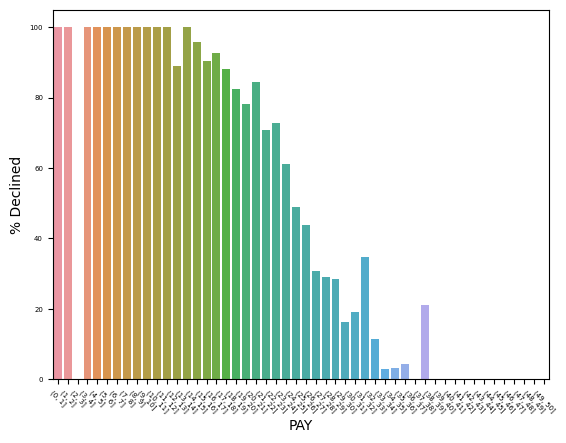

In [10]:
# Quick Visualization of likelyhood of rejection
sns.barplot(x=Clean_df.index, y=Clean_df['% Declined'])
plt.tick_params(axis='both', which='major', labelsize=5)
plt.xticks(rotation = -45)

As expected there is a reduction in the % of declined rides as we increase the pay offered to drivers. However, even with a low sensitivity (1$ intervals) we dont have enough data to plot a smooth transition between intervals. As we can see, there is noticeable sudden "jumps" within the (32, 33] and (39,39] intervals mostlikely caused by our low number of samples.

**Data Generation**

Given that both Decline and Accepted ride request both exhibit a Gaussian/Normal distribution we are able to generate further data points based on the characteristics (mean and standard deviation) of their respective distributions. We will therefore recreate these distributions with a sample size of 100.000.000 data points which will enable us to generate a more accurate estimate of which rides were accepted/declined for every driver offer range.

<AxesSubplot: ylabel='Count'>

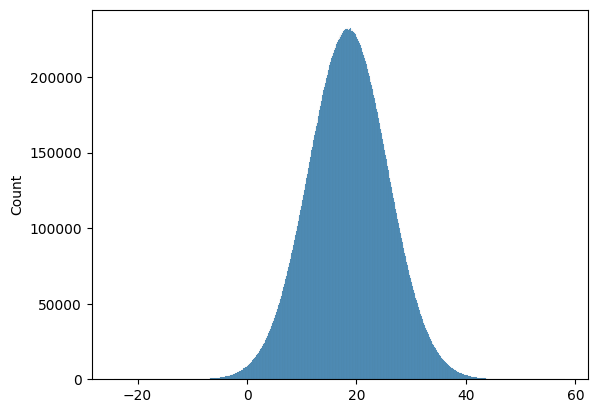

In [11]:
# Declined Data Generation
from numpy.random import normal
mean = data_clean[data_clean['ACCEPTED']==0]['PAY'].mean()
std = data_clean[data_clean['ACCEPTED']==0]['PAY'].std()
Dec_Pay = normal(loc=mean, scale=std, size=100000000)
sns.histplot(Dec_Pay)

<AxesSubplot: ylabel='Count'>

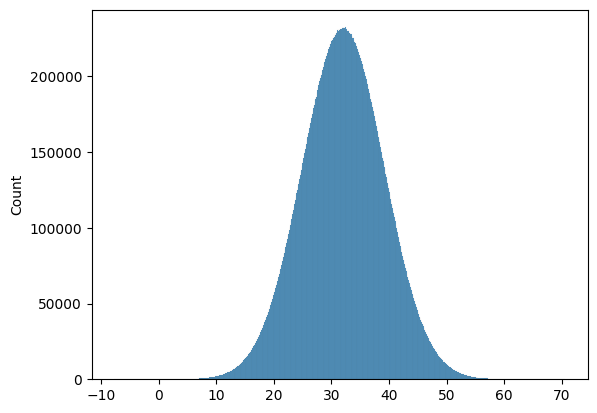

In [12]:
# Accepted Data Generation
from numpy.random import normal
mean = data_clean[data_clean['ACCEPTED']==1]['PAY'].mean()
std = data_clean[data_clean['ACCEPTED']==1]['PAY'].std()
Ac_Pay = normal(loc=mean, scale=std, size=100000000)
sns.histplot(Ac_Pay)

We can see in the above plots that the extreme values on the left side of out new Declined data set go beyond the 0 PAY point. Since we are not interested in unrealistic values we proceed to get rid of them:

In [16]:
# Getting rid of values under 0
Ac_Pay = Ac_Pay[Ac_Pay >= 0]
len(Ac_Pay)
Dec_Pay = Dec_Pay[Dec_Pay >= 0]
len(Dec_Pay)
print("Our sample size of accepted rides is now equal " + str(len(Ac_Pay)))
print("Our sample size of declined rides is now equal " + str(len(Dec_Pay)))


Our sample size of accepted rides is now equal 99999633
Our sample size of declined rides is now equal 99477085


The datramatic increase in sample size will enable us to both increase our precision in [% Decline] estimates and decrease our [PAY] intervals, effectively increasing our sensitivity. <br/>
We once again proceed to group our newly generated data into intervals. This time with 0.01 $ sizes. 

In [17]:
# Grouping Accepted/Declined data in 0.01 width intervals
Max = int(round(Ac_Pay.max(), 0))
Min = int(round(Dec_Pay.min(), 0))
# Creating intervals with 0.01 width
Intervals = []
start = 0
for i in range(Min, Max*100):                          
    Intervals.append(start)
    start = start + 0.01
Intervals = np.round(Intervals[:], 2)


Accepted = pd.DataFrame(Ac_Pay)
Declined = pd.DataFrame(Dec_Pay)

Accepted.rename(columns={0:'PAY'}, inplace=True)
Declined.rename(columns={0:'PAY'}, inplace=True)

Accepted.loc[:,'Counter'] = 1
Declined.loc[:,'Counter'] = 1

C_Accepted = Accepted.groupby(pd.cut(Accepted['PAY'], Intervals)).sum()
C_Declined = Declined.groupby(pd.cut(Declined['PAY'], Intervals)).sum()


<BarContainer object of 7099 artists>

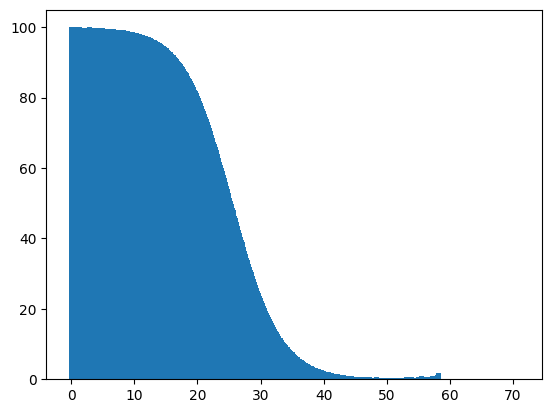

In [53]:
# Recreating our dataframe of interest 
Percent_df = C_Accepted.drop('PAY', axis=1).rename(columns={"Counter":"Accepted"})
Percent_df['Declined'] = C_Declined['Counter']

# Defining our [% Declined] column 
Percent_df['% Declined'] = round(Percent_df['Declined'] * 100 / (Percent_df['Accepted'] + Percent_df['Declined']), 2)
#Percent_df = Percent_df.dropna()



plt.bar(Intervals[1:], Percent_df['% Declined'][0:])
# Our result is an inverse sigmoid function as shown below

As seen above, our resulting [% Decline] describes an inverse sigmoid distribution. We can also appreciate some deviance from this distribution at the right tail end. This should be revised. However, since the 30$ marks our break even point it will be irrelevant for our specific case and therefore will be ignored going forward.

**Rejection function**

Now that we have our data cleaned and expanded we can proceed to our next step, creating functions that will optimize our profits given our problem restrictions. 

In [54]:
# This function will result in a float which when multipled by the amount
# of Ride Requests will output the total number of REJECTED Ride Requests
# given the parameter X which is the amount paid to the DRIVER
def Rejection_Rate(x):
    Percent = Percent_df.loc[x]['% Declined']/100
    return Percent

In [55]:
# This function will result in a float which when multipled by the amount
# of Ride Requests will output the total number of ACCEPTED Ride Requests
# given the parameter X which is the amount paid to the DRIVER
def Acceptance_Rate(x):
    Percent = 1 - Percent_df.loc[x]['% Declined']/100
    return Percent

In [57]:
# Example: 
# Number of rejections given 100 requests if we offered 30$ to the DRIVERS
100 * Rejection_Rate(30)

22.51

Bellow we describe in detail the contents of our main function [Profit] defined further bellow:

* The function accepts 1 input function (x) = Price offered to drivers


* There are 3 initial parameters preestablished by our particular problem a list and a counter:
1) Initial Value of Lambda: 1
2) Initial Rider Population: 1.000
3) Maximun Number of Possible Riders: 10.000
4) Exhausted Riders is a counter which must be bellow 10.000 in order for the function to continue
5) Profit is where the profit made by each itteration is saved

* It is itterated 12 times, one for every month.


* The function logic is as follows:
1) We establish our main restriction: If the total amount of Exhausted Riders (riders which have exited the App due one of the possibilities given by our problem) is greater than the total pool of riders [Max_Riders], then the function is halted.

2) Our first FOR loop calculates the distribution of [Riders] per [Number of Request] given the Lambda value and the number of riders per previous Lambda value. We then obtain two lists: Total_LambDist which is our total distribution of requests per individual, and Unique_Values which is a collection of unique values within our distribution.


3) Our second FOR loop organizes our previous distribution into a list NRi_NRe (Number of Riders per Number of Rides). This list contains the sum of riders per number of requests. <br/>

        For example:

        NRi_NRe = [300, 200, 100, 50, 10, 1]
        Unique_Values = [0, 1, 2, 3, 4, 6]

        300 Riders have requested 0 Rides
        200 Riders have requested 1 Ride
        100 Riders have requested 2 Rides
        50  Riders have requested 3 Rides
        10  Riders have Requested 4 Rides
        1   Rider  has  Requested 6 Rides

4) Our third FOR loop calculates the [Attrition] rate per NRi_NRe element. Attrition is determined by our problem, which states that a Rider will leave the service IF he does not use it (0 Rides taken) or all of his rides have been declined. This is done by multiplying every element within NRi_NRe by our previously described Rejection_Rate function to the power of its associated Unique_Value. <br/>

        For example: 

        Attrition[0] = 300 * 0.22^0 = 300 
        Attrition[1] = 200 * 0.22^1 =  44 
        Attrition[2] = 100 * 0.22^2 =   9 
        Attrition[3] =  50 * 0.22^3 =   2 
        Attrition[4] =  10 * 0.22^4 =   0.47 
        Attrition[5] =   1 * 0.22^6 =   0.02 

5) We proceed to calculate our profit for that month given our input X and append it to our Profit list.

6) We set up the variables for our next interration



In [58]:
import numpy as np
from scipy.stats import poisson
import itertools

# Initial Parameter
x = 20                                                                               # Example of amount payed to drivers
lamb = [1]                                                                           # Initial lambda value for our poisson distributions
Ri_Retention = [1000]                                                                # Initial number of riders for first month
Max_Riders = 10000                                                                   # Max. number of possible customers

Exhausted_Riders = 0                                                                 # Exhausted Rider counter set at 0
Profit = []                                                                          # Profit per itteration (month)

# Poisson Distribution of every previous Lambda
for month in range(0, 12):

# Halting if Riders are exhausted
    if Max_Riders <= Exhausted_Riders:
        break

    Total_LambDist = []                                                                  # List of lists containing all the distributions of each given lambda
    for ele in range(0, len(lamb)):
        Total_LambDist.append(poisson.rvs(mu=lamb[ele], size=int(round(Ri_Retention[ele],0))))

    Total_LambDist = [item for sublist in Total_LambDist for item in sublist]            # Our complete new distribution
    Unique_Values = list(set(Total_LambDist))                                            # Unique Number of Requests (0 Requests, 1 Request, 2 Requests...) 

# Number of Riders per Number of Requests
    NRi_NRe = []                                                                         # Initializing list which will contain the amount of riders per number of requests
    for i in range(0, len(Unique_Values)):                                               # Declaring for loop to iterate over every element of our Unique Values
        NRi_NRe.append(np.count_nonzero(Total_LambDist == Unique_Values[i]))             # Appending total amount of every unique number of requests

# Attrition Rate per Number of RidersxNumber of Requests
    Attrition = []                                                                       # Initializing a second list which will contain NRi_NRe(ele)*Rejection_Rate^Number of request
    for u in range(0, len(NRi_NRe)):                                                     # Declaring for loop to iterate over every element of total amount of unique requests
        Attrition.append(NRi_NRe[u]*Rejection_Rate(x)**Unique_Values[u])                 # Appending attrition rate defined as total amount of unique requests * rejection rate^number of requests performed

# Calculating benefit
    Earning = 30 * sum(Total_LambDist)*Acceptance_Rate(x)                # Total earnings per itteration
    Cost = x * sum(Total_LambDist)*Acceptance_Rate(x)                    # Total cost per itteration
    Benefit = Earning - Cost                                             # Total benefits per itteration
    Profit.append(Benefit)

# Setting up variables for next loop
    Ri_Retention = np.subtract(NRi_NRe, Attrition)[1:]                   # New Ri_Retention values
    Ri_Retention[0] = Ri_Retention[0] + 1000                             # New Riders Added
    lamb = Unique_Values[1:]                                             # New lambda values
    Exhausted_Riders = Exhausted_Riders + sum(Attrition)                 # New Exhausted Riders
Profit




[1919.8049999999998,
 2611.4849999999997,
 2908.2,
 3252.075,
 3261.9000000000005,
 3273.6899999999996,
 3607.7400000000007,
 3745.290000000001,
 3664.7250000000004,
 3786.5550000000003,
 3859.26]

In [59]:
# Creating a function based on the previously described loop
def profit(x):

    import numpy as np
    from scipy.stats import poisson
    import itertools

    # Initial Parameters
    lamb = [1]                                                                           
    Ri_Retention = [1000]                                                                
    Max_Riders = 10000                                                                   

    Exhausted_Riders = 0                                                                 
    Profit = []                                                                          

    # Poisson Distribution of every previous Lambda
    for month in range(0, 12):

    # Halting if Riders are exhausted
        if Max_Riders <= Exhausted_Riders:
            break

        Total_LambDist = []                                                                  
        for ele in range(0, len(lamb)):
            Total_LambDist.append(poisson.rvs(mu=lamb[ele], size=int(round(Ri_Retention[ele],0))))

        Total_LambDist = [item for sublist in Total_LambDist for item in sublist]            
        Unique_Values = list(set(Total_LambDist))                                             

    # Number of Riders per Number of Requests
        NRi_NRe = []                                                                         
        for i in range(0, len(Unique_Values)):                                               
            NRi_NRe.append(np.count_nonzero(Total_LambDist == Unique_Values[i]))             

    # Attrition Rate per Number of RidersxNumber of Requests
        Attrition = []                                                       
        for u in range(0, len(NRi_NRe)):                                          
            Attrition.append(NRi_NRe[u]*Rejection_Rate(x)**Unique_Values[u])      

    # Calculating benefit
        Earning = 30 * sum(Total_LambDist)*Acceptance_Rate(x)                
        Cost = x * sum(Total_LambDist)*Acceptance_Rate(x)                    
        Benefit = Earning - Cost                                             
        Profit.append(Benefit)

    # Setting up variables for next loop
        Ri_Retention = np.subtract(NRi_NRe, Attrition)[1:]                   
        Ri_Retention[0] = Ri_Retention[0] + 1000                             
        lamb = Unique_Values[1:]                                             
        Exhausted_Riders = Exhausted_Riders + sum(Attrition)                
    return sum(Profit)




Now that we have our fuction defined we can itterate over all our interval values of interest ([0.01, 30.00]) in order to observe the distribution of proffits across price ranges.

In [60]:
from tqdm import tqdm
# Itterating our function over every price interval
List_Profit = []

# We can limit the itterations from 0 up until 30 since its the break-even point
for i in tqdm(Intervals[np.where(Intervals == 0.01)[0][0]:np.where(Intervals == 30.01)[0][0]]):
    List_Profit.append(profit(i))




100%|██████████| 3000/3000 [02:18<00:00, 21.72it/s]


<BarContainer object of 3000 artists>

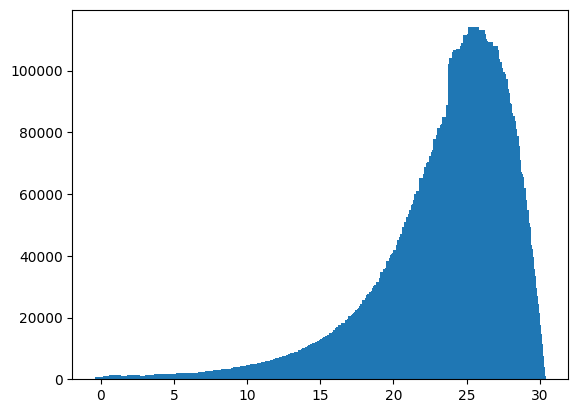

In [61]:
Profit_df = pd.DataFrame(List_Profit)
Profit_df = Profit_df.set_index([Intervals[1:3001]])
Profit_df.columns = ['Profit']


plt.bar(Intervals[1:3001], Profit_df['Profit'])

<AxesSubplot: ylabel='Profit'>

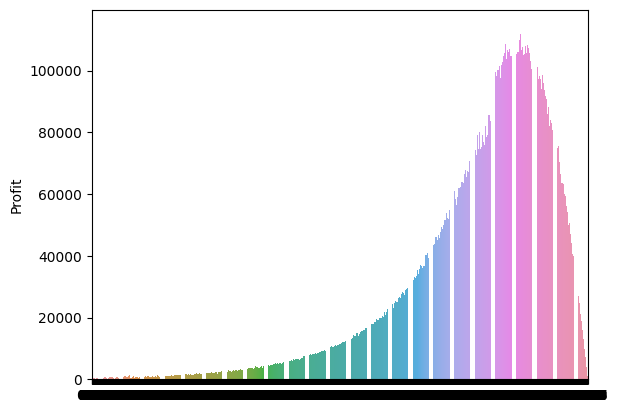

In [62]:
sns.barplot(x=Profit_df.index, y=Profit_df['Profit'])

Both figures shown above show the same distribution. They seem to represent a log normal distribution. However, this is taken from just one sample per interval. We could further itterate throughout the whole range of intervals but since we are only interested in maximizing our profits we can set a cut of point of above 100.000$, get the min and max intervals that satisfy this condition and itterate over this smaller sample, saving computing time.


In [63]:
Min_Interval = Profit_df[Profit_df['Profit']>=100000].index.min()
Max_Interval = Profit_df[Profit_df['Profit']>=100000].index.max()
print("Minimun Interval: " + str(Min_Interval))
print("Maximun Interval: " + str(Max_Interval))

Minimun Interval: 24.12
Maximun Interval: 27.11


In [66]:
Min_Interval

24.12

In [67]:
# Selecting only the interval [24.15, 26.99] and itterating 1000 times
from tqdm import tqdm
# Itterating our function over every price interval
T_LP_Interval = []

for u in tqdm(range(0, 10)):
    List_Profit_Interval = []
    for i in Intervals[np.where(Intervals == Min_Interval)[0][0]:np.where(Intervals == Max_Interval)[0][0]]:
        List_Profit_Interval.append(profit(i))
    T_LP_Interval.append(List_Profit_Interval)
    
Total = np.mean(T_LP_Interval, axis=0)



100%|██████████| 10/10 [03:58<00:00, 23.85s/it]


In [74]:
int(str(Max_Interval).replace('.', ''))

2412

In [75]:
Total = np.mean(T_LP_Interval, axis=0)
Total_df = pd.DataFrame(Total)
Total_df = Total_df.set_index([Intervals[
    int(str(Min_Interval).replace('.', '')):int(str(Max_Interval).replace('.', ''))]])
Total_df.columns = ['Profit']
Total_df



,Profit
24.12,84853.614031
24.13,87415.640253
24.14,85447.101042
24.15,82079.660520
24.16,87030.108564
...,...
27.06,97814.953656
27.07,97854.210009
27.08,95958.885966
27.09,96841.745140


<AxesSubplot: ylabel='Profit'>

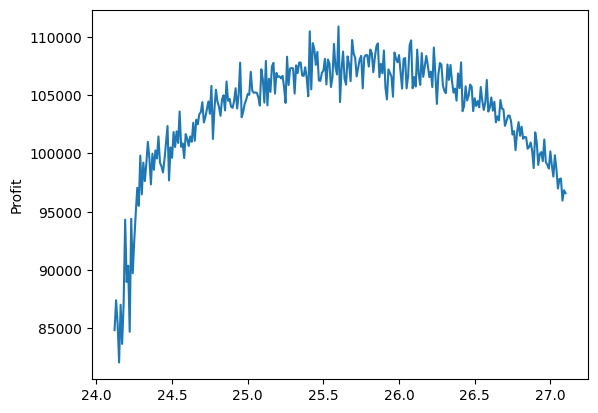

In [76]:
sns.lineplot(x=Total_df.index, y=Total_df['Profit'])

<AxesSubplot: ylabel='Profit'>

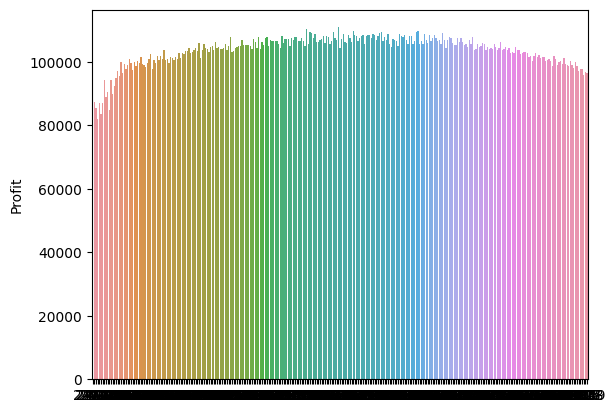

In [77]:
sns.barplot(x=Total_df.index, y=Total_df['Profit'])

In [78]:
Min = Total_df[Total_df['Profit']>107500].index.min()
Max = Total_df[Total_df['Profit']>107500].index.max()
print(Min)
print(Max)

24.95
26.41


<AxesSubplot: ylabel='Profit'>

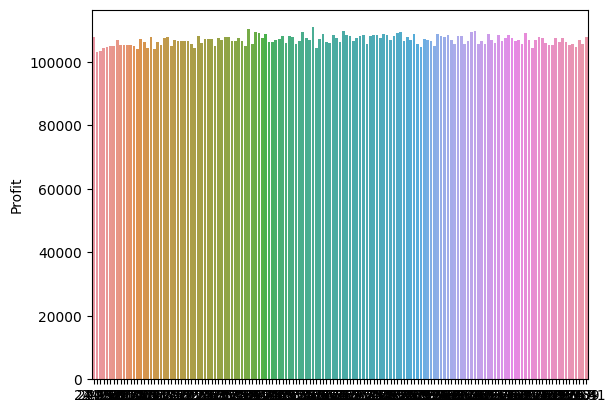

In [79]:
Ideal_range = Total_df[(Total_df.index >= Min) & (Total_df.index <= Max)]
Ideal_range.max() - Ideal_range.min()
sns.barplot(x=Ideal_range.index, y=Ideal_range['Profit'])

In [80]:
Ideal_range['Profit'].mean()
print("The average maximun value for a fixed price strategy is: " + str(Ideal_range['Profit'].mean()))
print("Which can be achieved by charging drivers anywhere between: " + str(Min) + " and " + str(Max))

The average maximun value for a fixed price strategy is: 106886.72722364693
Which can be achieved by charging drivers anywhere between: 24.95 and 26.41


We can now check this our Ideal Range describes a normal distribution

In [86]:
from scipy.stats import shapiro 

#Shapiro-Wilk test for normality
print(shapiro(Ideal_range['Profit']))
print("Mean: " + str(Ideal_range['Profit'].mean()))
print("STD : " + str(Ideal_range['Profit'].std()))

ShapiroResult(statistic=0.9950666427612305, pvalue=0.9025587439537048)
Mean: 106886.72722364693
STD : 1488.8363431593589


Since it seems to be normal distribution we can now gage the probability of achieving a given profit goal. This proceedure is much like that which we have already established previously for generating our data. We extract the mean and standard deviation and itterate over a given amount. We can then give with a 95% confidence interval our expected profits.

<AxesSubplot: ylabel='Count'>

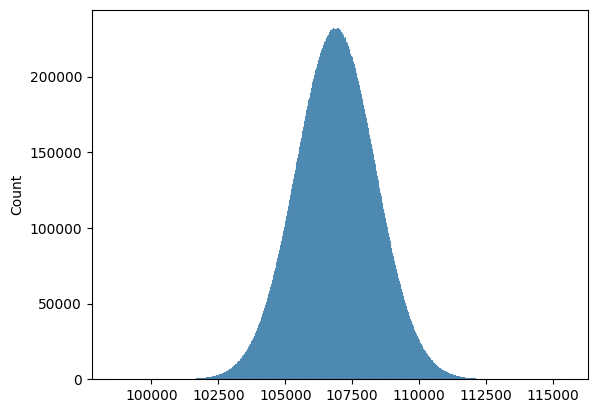

In [88]:
from numpy.random import normal
mean = Ideal_range['Profit'].mean()
std = Ideal_range['Profit'].std()
Profit_Range = normal(loc=mean, scale=std, size=100000000)
sns.histplot(Profit_Range)

In [100]:
Percentile_Min = np.percentile(Profit_Range, 2.5)
Percentile_Max = np.percentile(Profit_Range, 97.5)
print("When using a fixed priced strategy that pays anywhere between our established range [" + str(Min) 
      + "," + str(Max) + "] we can assert with 95% confidence that our profits will fall within the following"
      " range : [" + str(round(Percentile_Min, 2)) + "," + str(round(Percentile_Max,2)) + "] $") 

When using a fixed priced strategy that pays anywhere between our established range [24.95,26.41] we can assert with 95% confidence that our profits will fall within the following range : [103969.16,109805.48] $
